# Data and information quality project

### Project description: DQ problem is Feature Dependency, ML task is Classification

Given a dataset, inject more and more features with different type (linear,nonlinear,combination of features) and magnitude(low,high,negative) of correlation.

Inspect the changes in performance of ML models

### Import all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from A_data_collection import make_dataset_for_classification
from D_data_analysis import classification
from E_plot_results import plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/Users/ajeje/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/ajeje/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
import warnings

# Ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### List of Classification algorithms

In [3]:
CLASSIFICATION_ALGORITHMS = ["DecisionTree","LogisticRegression","KNN","RandomForest","AdaBoost","MLP"]

#Seed is set in order to assure reproducibility of experiments
SEED = 2023

### Utility functions

In [4]:
def data_exploration(X_passed,y):
    # Convert the array to a DataFrame for better visualization (optional)
    number_of_columns= X_passed.shape[1]
    columns=list()
    for i in range(0,number_of_columns):
        columns.append(f"Feature {i}")
    df = pd.DataFrame(X_passed, columns=columns)

    # Display basic information about the structure
    print("Structure Information:")
    print(df.info())

    # Display the first few rows of the structure
    print("\nFirst Few Rows of the Structure:")
    print(df.head())

    # Summary statistics of the structure
    print("\nSummary Statistics:")
    print(df.describe())


    # Visualize the distribution of each feature using histograms
    df.hist(bins=20, figsize=(15, 10))
    plt.suptitle("Histograms of Features")
    plt.show()

    # Visualize the correlation matrix using a heatmap
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix")
    plt.show()

#APPLY PCA
    df['Target'] = y

    # Standardize the data
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(df.drop('Target', axis=1))

    # Perform PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_standardized)

    # Create a DataFrame with the principal components
    pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

    # Concatenate the principal components with the original DataFrame and the target variable
    final_df = pd.concat([pc_df, df['Target']], axis=1)

    # Visualize the data in the reduced-dimensional space, colored by the target variable
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='Target', data=final_df, palette='viridis', alpha=0.7)
    plt.title('PCA: Reduced-dimensional Space with Target Variable')
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.legend(title='Target', loc='upper right', labels=['Class 0', 'Class 1'])
    plt.show()

In [5]:
def inject_one_correlated_feature(X, target_feature_index, correlation_strength):
    
    # Ensure that the correlation coefficient is within the valid range
    correlation_strength = np.clip(correlation_strength, -1, 1)

    new_feature = correlation_strength * X[:, target_feature_index] + np.sqrt(1 - correlation_strength**2) * np.random.randn(1000)

    
    # Inject the new feature into the original dataset
    X_with_new_feature = np.column_stack((X, new_feature.reshape(-1, 1)))


    # Print the correlation matrix to verify the correlation
    correlation_matrix = np.corrcoef(X_with_new_feature, rowvar=False)
    

    # Access the correlation between the original feature and the new feature
    correlation_with_target_feature = correlation_matrix[-1, target_feature_index]
    print(f"Correlation with the target feature: {correlation_with_target_feature}")



    return X_with_new_feature

In [30]:
def inject_one_non_linear_correlated_feature(number_of_experiment,X, target_feature_index):

    # Introduce a nonlinear feature with a quadratic transformation
    if number_of_experiment==7:
        new_nonlinear_feature = X[:, target_feature_index]**2 + np.random.randn(1000)
    elif number_of_experiment==8:
        new_nonlinear_feature = np.cos(X[:, target_feature_index]) + np.random.randn(1000)
    
    # Inject the new feature into the original dataset
    X_with_new_feature = np.column_stack((X, new_nonlinear_feature.reshape(-1, 1)))


    # Print the correlation matrix to verify the correlation
    correlation_matrix = np.corrcoef(X_with_new_feature, rowvar=False)
    
    
    # Access the correlation between the original feature and the new feature
    correlation_with_target_feature = correlation_matrix[-1, target_feature_index]
    print(f"Correlation with the target feature: {correlation_with_target_feature}")




    return X_with_new_feature

In [6]:
def inject_combination_of_features(number_of_experiment,X,i,j):

    # Introduce a combination feature with a quadratic transformation
    if number_of_experiment==9:
        new_combination_feature = X[:,i] * X[:,j]
    
    
    # Inject the new feature into the original dataset
    X_with_new_feature = np.column_stack((X, new_combination_feature.reshape(-1, 1)))


    return X_with_new_feature

In [7]:
def generate_latex_tables_and_save_files(data, algorithms, column_name, column_values, path):
    num_algorithms = len(data)
    num_trials = len(data[0])

    # Check if column_values length matches the number of trials
    if len(column_values) != num_trials:
        raise ValueError("The length of column_values must match the number of trials")

    # Initialize tables
    mean_perf_table = [['' for _ in range(num_algorithms)] for _ in range(num_trials)]
    distance_table = [['' for _ in range(num_algorithms)] for _ in range(num_trials)]
    speed_table = [['' for _ in range(num_algorithms)] for _ in range(num_trials)]

    # Fill tables with data
    for algo_idx, algorithm in enumerate(data):
        for trial_idx, trial in enumerate(algorithm):
            mean_perf_table[trial_idx][algo_idx] = trial['mean_perf']
            distance_table[trial_idx][algo_idx] = trial['distance']
            speed_table[trial_idx][algo_idx] = trial['speed']

    # Function to create LaTeX table and save to file
    def create_latex_table_and_save(data, title, filename):
        latex = "\\begin{table}[h!]\n\\centering\n\scalebox{0.8}{\n"
        latex += "\\begin{tabular}{|l|" + " c |" * len(data[0]) + "}\n\\hline\n"
        latex += f" {column_name} & " + " & ".join(algorithms) + "\\\\\n\\hline\n"
        for trial_idx, row in enumerate(data):
            latex += f" {column_values[trial_idx]} & " + " & ".join([f"{val:.4f}" for val in row]) + "\\\\\n\\hline\n"
        latex += "\\end{tabular}}\n"
        latex += f"\\caption{{{title}}}\n"
        latex += "\\end{table}\n"
        
        #SUBSTITUTE THIS PATH WITH THE PATH WHERE THE REPO WAS CLONED OR WHERE YOU WANT TO SAVE YOUR DATA
        with open(f"/Users/ajeje/Desktop/polimi/MASTER/S1_2023/DATA QUALITY/project/Data_quality_project/SCRIPTS/tables/{filename}", 'w') as file: 
            file.write(latex)

    # Generate LaTeX tables and save to files
    create_latex_table_and_save(mean_perf_table, "Mean Performance", f"{path}/mean_perf_table.tex")
    create_latex_table_and_save(distance_table, "Distance", f"{path}/distance_table.tex")
    create_latex_table_and_save(speed_table, "Speed", f"{path}/speed_table.tex")







### Create dataset for most of the experiments. And some data analysis

In [8]:
X, y = make_dataset_for_classification(n_samples=1000, n_features=5, n_informative=5, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, seed=2023)

Structure Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Feature 0  1000 non-null   float64
 1   Feature 1  1000 non-null   float64
 2   Feature 2  1000 non-null   float64
 3   Feature 3  1000 non-null   float64
 4   Feature 4  1000 non-null   float64
dtypes: float64(5)
memory usage: 39.2 KB
None

First Few Rows of the Structure:
   Feature 0  Feature 1  Feature 2  Feature 3  Feature 4
0  -3.044852   0.401225   1.876653   1.566605  -2.132950
1   1.445783   1.330753   1.140285   0.706253   2.422165
2   2.404213   1.620161  -0.710273  -3.793487   1.183956
3   1.573431  -0.558834   0.359672   0.777892   2.637753
4  -0.849001   2.114740   3.329424  -1.255837  -1.173801

Summary Statistics:
         Feature 0    Feature 1    Feature 2    Feature 3    Feature 4
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000
mean   

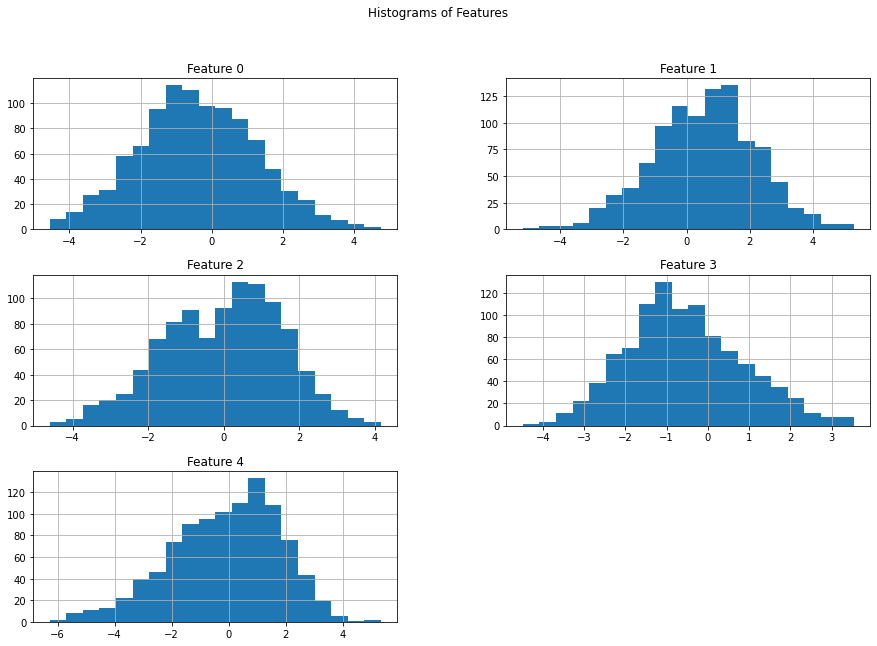

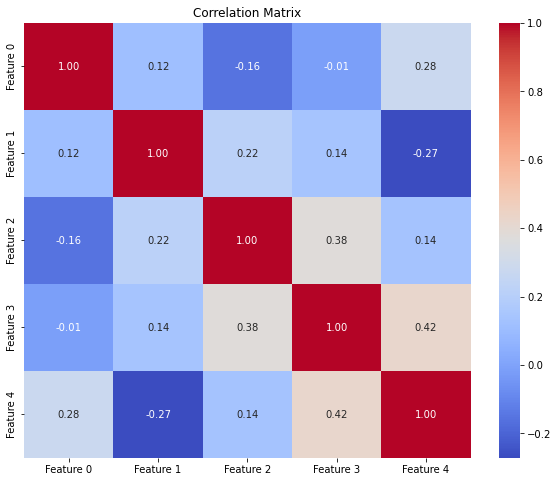

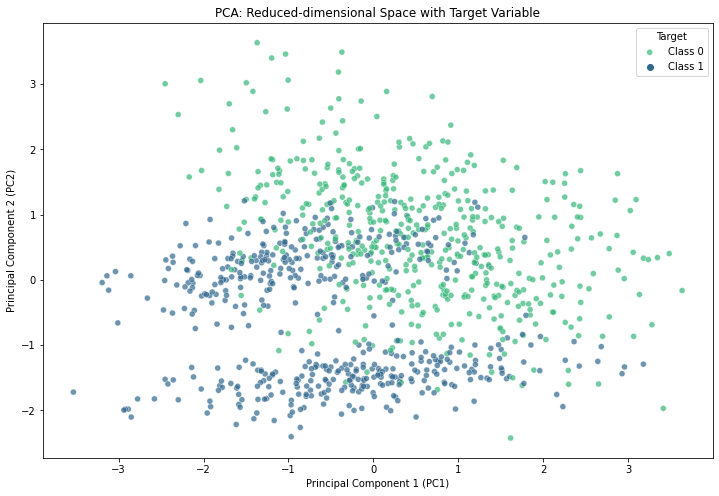

In [9]:
data_exploration(X,y)

### Experiment Function

In [10]:
def perform_experiment(number_of_experiment,X,y,CLASSIFICATION_ALGORITHMS,correlation_strength):
    #initialize the array for the results for each algorithm
    results_for_each_algorithm = []

    for algorithm in CLASSIFICATION_ALGORITHMS: # FIRST CICLE ON THE ALGORITHMS

        results_single_algorithm = []

        #base model on base original dataset
        results_base_analysis = classification(X, y, algorithm, SEED)
        results_single_algorithm.append(results_base_analysis)

        #HERE WE INTRODUCE A FSM

        #EXPERIMENT 1: ONE CORRELATED FEATURE WITH INCREASING CORRELATION FROM 0 TILL 1
        #EXPERIMENT 2: ONE CORRELATED FEATURE WITH DECREASING CORRELATION FROM 0 TILL -1
        if number_of_experiment in [1,2]:
            correlation_coefficient = correlation_strength
            for i in range(0, 10): # SECOND CICLE ON THE NUMBER OF POLLUTED DATASET THAT YOU WANT TO CREATE WITH DIFFERENT % OF POLLUTION
                #Data pollution
                
                existing_feature_index = 0  # Choose the existing feature with which you want to correlate
                if number_of_experiment==1:
                    correlation_coefficient = correlation_coefficient + 0.08 # Adjust the correlation strength

                    if i==9:
                        correlation_coefficient=1
                else:
                    correlation_coefficient = correlation_coefficient - 0.08 # Adjust the correlation strength

                    if i==9:
                        correlation_coefficient=-1
                

                X_with_new_feature = inject_one_correlated_feature(X, existing_feature_index, correlation_coefficient)
                
                
                # DATA ANALYSIS
            
                results_1_analysis = classification(X_with_new_feature, y, algorithm, SEED)
                results_single_algorithm.append(results_1_analysis)

        #EXPERIMENT 3: GROWING NUMBER OF FEATURES WITH LOW CORRELATION
        #EXPERIMENT 4: GROWING NUMBER OF FEATURES WITH MEDIUM CORRELATION
        #EXPERIMENT 5: GROWING NUMBER OF FEATURES WITH HIGH CORRELATION
        #EXPERIMENT 6: GROWING NUMBER OF FEATURES WITH NEGATIVE CORRELATION
        #EXPERIMENT 7: NON LINEAR QUADRATIC
        #EXPERIMENT 8: NON LINEAR COSINE
        
        #THE RESULT DEPENDS ON THE CORRELATION STRENGTH PARAMETER 
        elif number_of_experiment in [3,4,5,6,7,8]:

            X_with_new_feature = X

            for i in range(0, 15): # SECOND CICLE ON THE NUMBER OF POLLUTED DATASET THAT YOU WANT TO CREATE WITH DIFFERENT % OF POLLUTION
               
                #Data pollution
                if number_of_experiment in [3,4,5,6]:
                    for j in range(0,X.shape[1]):
                        existing_feature_index = j
                        print(existing_feature_index)
                        X_with_new_feature = inject_one_correlated_feature(X_with_new_feature, existing_feature_index, correlation_strength)
                    
                    # DATA ANALYSIS
                    
                    results_1_analysis = classification(X_with_new_feature, y, algorithm, SEED)
                    results_single_algorithm.append(results_1_analysis)

                    print(X_with_new_feature.shape)

                #EXPERIMENT 7 AND 8: NON LINEAR CORRELATED FEATURE
                elif number_of_experiment in [7,8]:
                    
                    for j in range(0,X.shape[1]):
                        existing_feature_index = j
                        print(existing_feature_index)
                        X_with_new_feature = inject_one_non_linear_correlated_feature(number_of_experiment,X_with_new_feature, existing_feature_index)
                    
                    # DATA ANALYSIS
                    
                    results_1_analysis = classification(X_with_new_feature, y, algorithm, SEED)
                    results_single_algorithm.append(results_1_analysis)

                    print(X_with_new_feature.shape)

        #EXPERIMENT 9: COMBINATION OF FEATURES
        elif number_of_experiment==9:

            X_with_new_feature= X

            count_debug=0
            for i in range(0,5):
                for j in range(0,5):
                    if i>=j:
                        pass
                    else:
                        count_debug+=1
                        X_with_new_feature = inject_combination_of_features(number_of_experiment,X_with_new_feature,i,j)
                        results_1_analysis = classification(X_with_new_feature, y, algorithm, SEED)
                        results_single_algorithm.append(results_1_analysis)

                        print(X_with_new_feature.shape)

            print('DEBUG',count_debug)

        elif number_of_experiment==10:
            
            results_single_algorithm = []

            correlation_coefficient = correlation_strength
            
            for i in range(0, 20): # SECOND CICLE ON THE NUMBER OF POLLUTED DATASET THAT YOU WANT TO CREATE WITH DIFFERENT % OF POLLUTION
                #Data pollution
                
                
                correlation_coefficient = correlation_coefficient + 0.11 # Adjust the correlation strength

                if i==0:
                    correlation_coefficient = -1
                elif i==19:
                    correlation_coefficient = 1

                for j in range(0,X.shape[1]):
                    existing_feature_index=j
                    X_with_new_feature = inject_one_correlated_feature(X, existing_feature_index, correlation_coefficient)
                
                
                # DATA ANALYSIS
            
                results_1_analysis = classification(X_with_new_feature, y, algorithm, SEED)
                results_single_algorithm.append(results_1_analysis)
            



        results_for_each_algorithm.append(results_single_algorithm)
    

    return results_for_each_algorithm

### Experiment 1: introduce one correlated feature with an increasing correlation strength that starts with 0 till 1

Correlation is around 0.5 so not so high. Let's see how increasing the number of correlated features impacts on the results

In [11]:
results_for_each_algorithm = perform_experiment(1,X,y,CLASSIFICATION_ALGORITHMS,0)

print(results_for_each_algorithm)

Training for DecisionTree...
Correlation with the target feature: 0.11861385708039987
Training for DecisionTree...
Correlation with the target feature: 0.32611894856754126
Training for DecisionTree...
Correlation with the target feature: 0.37156604716177066
Training for DecisionTree...
Correlation with the target feature: 0.4984102851322648
Training for DecisionTree...
Correlation with the target feature: 0.5952355539956281
Training for DecisionTree...
Correlation with the target feature: 0.6625156729794891
Training for DecisionTree...
Correlation with the target feature: 0.758550404414449
Training for DecisionTree...
Correlation with the target feature: 0.808233469878927
Training for DecisionTree...
Correlation with the target feature: 0.8590184897303722
Training for DecisionTree...
Correlation with the target feature: 1.0
Training for DecisionTree...
Training for LogisticRegression...
Correlation with the target feature: 0.16290329600661266
Training for LogisticRegression...
Correlat

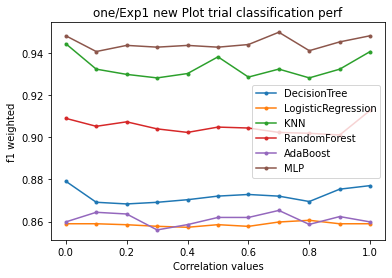

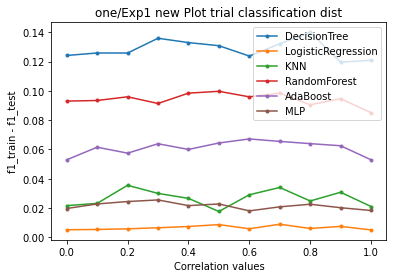

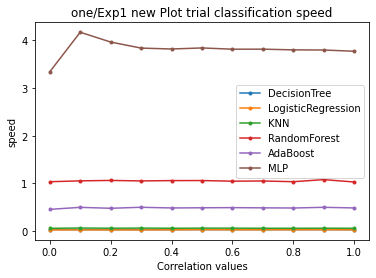

In [12]:
plot(x_axis_values=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], x_label="Correlation values", results=results_for_each_algorithm, title="one/Exp1 new Plot trial classification perf", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], x_label="Correlation values", results=results_for_each_algorithm, title="one/Exp1 new Plot trial classification dist", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], x_label="Correlation values", results=results_for_each_algorithm, title="one/Exp1 new Plot trial classification speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")


In [13]:
column_name = 'Correlation Values'
column_values = [0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]


# Call the function with the new parameters
generate_latex_tables_and_save_files(results_for_each_algorithm, CLASSIFICATION_ALGORITHMS, column_name, column_values, 'one')


### Experiment 2: introduce one correlated feature with a decresing correlation strength that starts with 0 till -1

In [14]:
results_for_each_algorithm = perform_experiment(2,X,y,CLASSIFICATION_ALGORITHMS,0)

print(results_for_each_algorithm)

Training for DecisionTree...
Correlation with the target feature: -0.10695460834914307
Training for DecisionTree...
Correlation with the target feature: -0.24901954675886215
Training for DecisionTree...
Correlation with the target feature: -0.3592414033451729
Training for DecisionTree...
Correlation with the target feature: -0.476649834180238
Training for DecisionTree...
Correlation with the target feature: -0.5982657380061066
Training for DecisionTree...
Correlation with the target feature: -0.6815583323484545
Training for DecisionTree...
Correlation with the target feature: -0.7464109874449751
Training for DecisionTree...
Correlation with the target feature: -0.7897186008126215
Training for DecisionTree...
Correlation with the target feature: -0.8584940692059189
Training for DecisionTree...
Correlation with the target feature: -1.0
Training for DecisionTree...
Training for LogisticRegression...
Correlation with the target feature: -0.12216185762992368
Training for LogisticRegression.

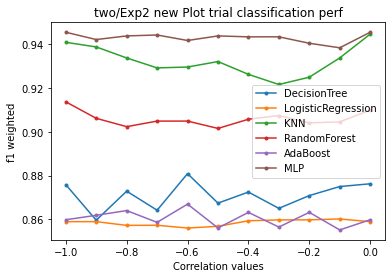

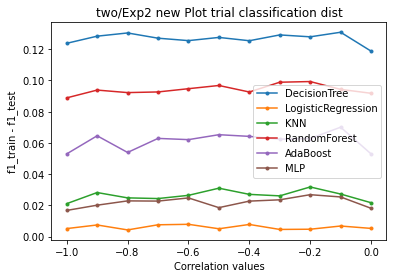

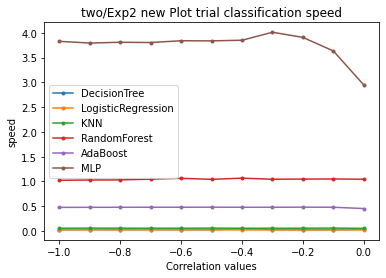

In [15]:
plot(x_axis_values=[0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1], x_label="Correlation values", results=results_for_each_algorithm, title="two/Exp2 new Plot trial classification perf", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=[0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1], x_label="Correlation values", results=results_for_each_algorithm, title="two/Exp2 new Plot trial classification dist", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=[0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1], x_label="Correlation values", results=results_for_each_algorithm, title="two/Exp2 new Plot trial classification speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

In [16]:
column_name = 'Correlation Values'
column_values = [0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1]


# Call the function with the new parameters
generate_latex_tables_and_save_files(results_for_each_algorithm, CLASSIFICATION_ALGORITHMS, column_name, column_values, 'two')


### Experiment 3: growing number of features low correlation

In [17]:
results_for_each_algorithm = perform_experiment(3,X,y,CLASSIFICATION_ALGORITHMS,0.35)

print(results_for_each_algorithm)

Training for DecisionTree...
0
Correlation with the target feature: 0.5586488200398877
1
Correlation with the target feature: 0.5122792749375774
2
Correlation with the target feature: 0.4955078838097485
3
Correlation with the target feature: 0.48598406836160085
4
Correlation with the target feature: 0.578253469659128
Training for DecisionTree...
(1000, 10)
0
Correlation with the target feature: 0.5149993592734884
1
Correlation with the target feature: 0.517466855719195
2
Correlation with the target feature: 0.5082957921176511
3
Correlation with the target feature: 0.46749010920745065
4
Correlation with the target feature: 0.5934581922928271
Training for DecisionTree...
(1000, 15)
0
Correlation with the target feature: 0.5086959428155265
1
Correlation with the target feature: 0.512274525420983
2
Correlation with the target feature: 0.501237943360788
3
Correlation with the target feature: 0.4592046784273322
4
Correlation with the target feature: 0.596350052357853
Training for DecisionTre

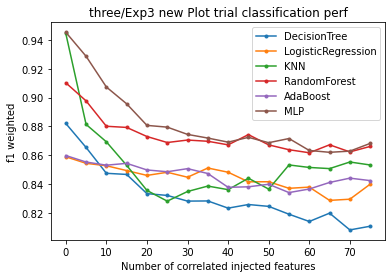

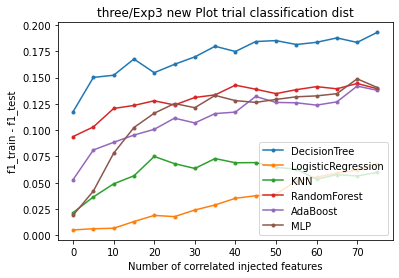

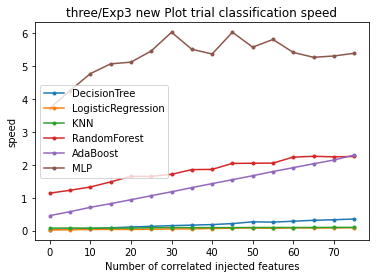

In [18]:
result_array = np.arange(0, 16 * 5, 5)
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="three/Exp3 new Plot trial classification perf", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="three/Exp3 new Plot trial classification dist", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="three/Exp3 new Plot trial classification speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

In [19]:
column_name = 'Injected features'
column_values = result_array


# Call the function with the new parameters
generate_latex_tables_and_save_files(results_for_each_algorithm, CLASSIFICATION_ALGORITHMS, column_name, column_values, 'three')


### Experiment 4: growing number of feature with medium correlation

In [20]:
results_for_each_algorithm = perform_experiment(4,X,y,CLASSIFICATION_ALGORITHMS,0.5)

print(results_for_each_algorithm)

Training for DecisionTree...
0
Correlation with the target feature: 0.6727967327361429
1
Correlation with the target feature: 0.685331150505317
2
Correlation with the target feature: 0.6496364274678269
3
Correlation with the target feature: 0.6284765594850058
4
Correlation with the target feature: 0.7408031542770859
Training for DecisionTree...
(1000, 10)
0
Correlation with the target feature: 0.7049355704043576
1
Correlation with the target feature: 0.658149565404973
2
Correlation with the target feature: 0.6545285538529663
3
Correlation with the target feature: 0.6435310285541734
4
Correlation with the target feature: 0.7246864871598343
Training for DecisionTree...
(1000, 15)
0
Correlation with the target feature: 0.6995686450757466
1
Correlation with the target feature: 0.6910090753307442
2
Correlation with the target feature: 0.6770176365913737
3
Correlation with the target feature: 0.6527567904234763
4
Correlation with the target feature: 0.7335012296633111
Training for DecisionTr

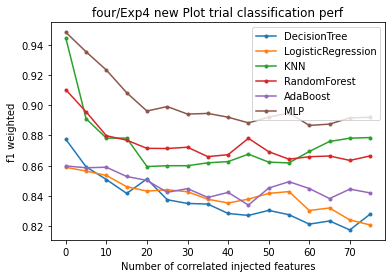

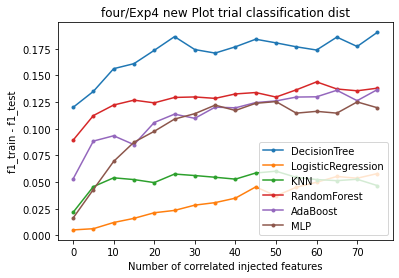

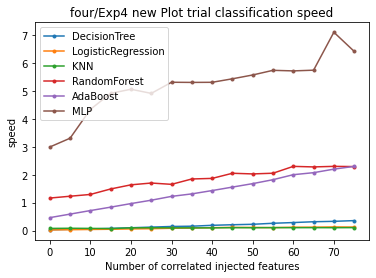

In [21]:
result_array = np.arange(0, 16 * 5, 5)
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="four/Exp4 new Plot trial classification perf", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="four/Exp4 new Plot trial classification dist", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="four/Exp4 new Plot trial classification speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

In [22]:
column_name = 'Injected features'
column_values = result_array


# Call the function with the new parameters
generate_latex_tables_and_save_files(results_for_each_algorithm, CLASSIFICATION_ALGORITHMS, column_name, column_values, 'four')


### Experiment 5: growing number of feature with high correlation

In [23]:
results_for_each_algorithm = perform_experiment(5,X,y,CLASSIFICATION_ALGORITHMS,0.85)

print(results_for_each_algorithm)

Training for DecisionTree...
0
Correlation with the target feature: 0.938006460463814
1
Correlation with the target feature: 0.9323847926458263
2
Correlation with the target feature: 0.9307474071096232
3
Correlation with the target feature: 0.9187870222812403
4
Correlation with the target feature: 0.9478741189798336
Training for DecisionTree...
(1000, 10)
0
Correlation with the target feature: 0.933148722179627
1
Correlation with the target feature: 0.9321996282493776
2
Correlation with the target feature: 0.9295469660137422
3
Correlation with the target feature: 0.9121908587949121
4
Correlation with the target feature: 0.9497326872353888
Training for DecisionTree...
(1000, 15)
0
Correlation with the target feature: 0.93564946755517
1
Correlation with the target feature: 0.941052990372534
2
Correlation with the target feature: 0.9290020127799603
3
Correlation with the target feature: 0.915869605178554
4
Correlation with the target feature: 0.9498118837636055
Training for DecisionTree..

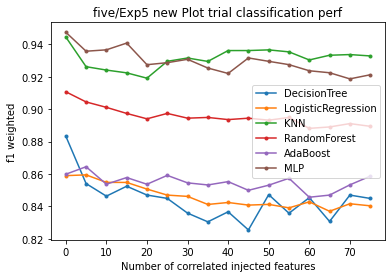

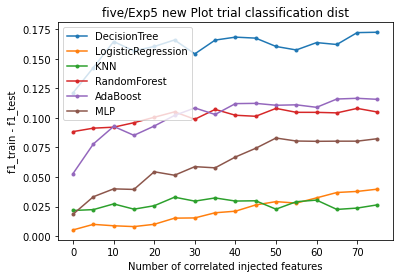

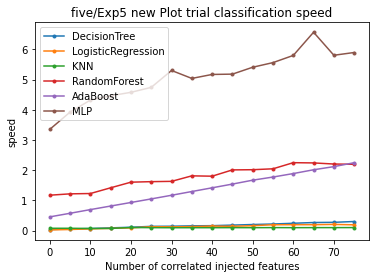

In [24]:
result_array = np.arange(0, 16 * 5, 5)
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="five/Exp5 new Plot trial classification perf", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="five/Exp5 new Plot trial classification dist", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="five/Exp5 new Plot trial classification speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

In [25]:
column_name = 'Injected features'
column_values = result_array


# Call the function with the new parameters
generate_latex_tables_and_save_files(results_for_each_algorithm, CLASSIFICATION_ALGORITHMS, column_name, column_values, 'five')


### Experiment 6: growing number of feature with negative correlation

In [26]:
results_for_each_algorithm = perform_experiment(6,X,y,CLASSIFICATION_ALGORITHMS,-0.5)

print(results_for_each_algorithm)

Training for DecisionTree...
0
Correlation with the target feature: -0.7086623892053632
1
Correlation with the target feature: -0.6937563032581703
2
Correlation with the target feature: -0.690928323466408
3
Correlation with the target feature: -0.6049836133192725
4
Correlation with the target feature: -0.7370985530409307
Training for DecisionTree...
(1000, 10)
0
Correlation with the target feature: -0.6777186360095466
1
Correlation with the target feature: -0.6657087791664247
2
Correlation with the target feature: -0.6660844927733522
3
Correlation with the target feature: -0.6459491095597373
4
Correlation with the target feature: -0.7486178020294436
Training for DecisionTree...
(1000, 15)
0
Correlation with the target feature: -0.6959646567953051
1
Correlation with the target feature: -0.6885518927025235
2
Correlation with the target feature: -0.6871211128293233
3
Correlation with the target feature: -0.6381760248487324
4
Correlation with the target feature: -0.7331643814349198
Trainin

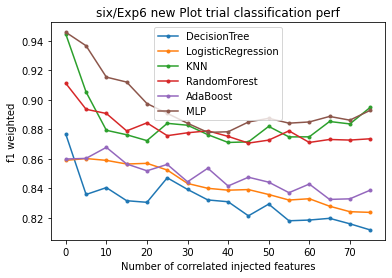

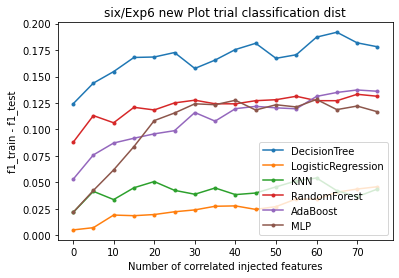

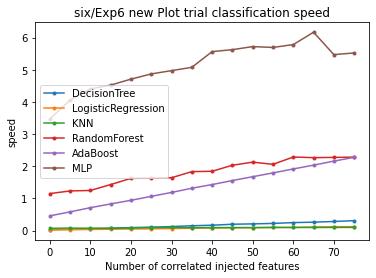

In [27]:
result_array = np.arange(0, 16 * 5, 5)
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="six/Exp6 new Plot trial classification perf", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="six/Exp6 new Plot trial classification dist", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="six/Exp6 new Plot trial classification speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

In [28]:
column_name = 'Injected features'
column_values = result_array


# Call the function with the new parameters
generate_latex_tables_and_save_files(results_for_each_algorithm, CLASSIFICATION_ALGORITHMS, column_name, column_values, 'six')


### Experiment 7: inject more and more non linear correlated features (power of 2 of a feature)

In [31]:
results_for_each_algorithm = perform_experiment(7,X,y,CLASSIFICATION_ALGORITHMS,0)

print(results_for_each_algorithm)

Training for DecisionTree...
0
Correlation with the target feature: -0.2806222763965309
1
Correlation with the target feature: 0.32132419754863845
2
Correlation with the target feature: -0.18749178604669253
3
Correlation with the target feature: -0.3361501821205516
4
Correlation with the target feature: -0.3724398533674537
Training for DecisionTree...
(1000, 10)
0
Correlation with the target feature: -0.26412976721177456
1
Correlation with the target feature: 0.31605102462831247
2
Correlation with the target feature: -0.1720298675778301
3
Correlation with the target feature: -0.32221473196912265
4
Correlation with the target feature: -0.37308748182987506
Training for DecisionTree...
(1000, 15)
0
Correlation with the target feature: -0.28244559606449765
1
Correlation with the target feature: 0.31119744064018434
2
Correlation with the target feature: -0.19470873919291568
3
Correlation with the target feature: -0.3127153755010421
4
Correlation with the target feature: -0.36468599221045334

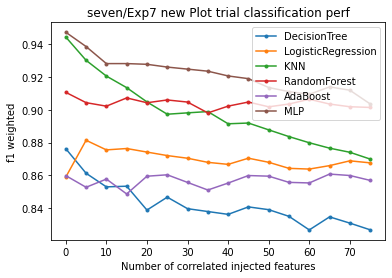

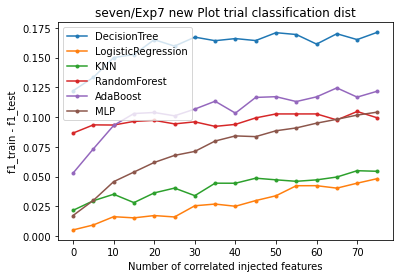

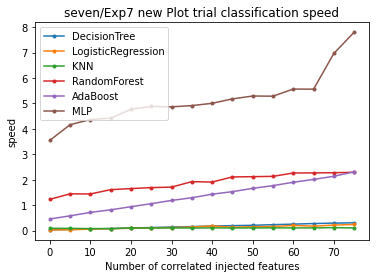

In [32]:
result_array = np.arange(0, 16 * 5, 5)
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="seven/Exp7 new Plot trial classification perf", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="seven/Exp7 new Plot trial classification dist", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="seven/Exp7 new Plot trial classification speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

In [33]:
column_name = 'Injected features'
column_values = result_array


# Call the function with the new parameters
generate_latex_tables_and_save_files(results_for_each_algorithm, CLASSIFICATION_ALGORITHMS, column_name, column_values, 'seven')


### Experiment 8: inject more and more non linear correlated features (cosine)

In [34]:
results_for_each_algorithm = perform_experiment(8,X,y,CLASSIFICATION_ALGORITHMS,0)

print(results_for_each_algorithm)

Training for DecisionTree...
0
Correlation with the target feature: 0.15623484373816562
1
Correlation with the target feature: -0.15716229533846435
2
Correlation with the target feature: 0.049132044158241434
3
Correlation with the target feature: 0.16229175123374873
4
Correlation with the target feature: 0.03295245344319337
Training for DecisionTree...
(1000, 10)
0
Correlation with the target feature: 0.1059447687701098
1
Correlation with the target feature: -0.14286984981332965
2
Correlation with the target feature: 0.03251927767039778
3
Correlation with the target feature: 0.18131045703303011
4
Correlation with the target feature: 0.03247482237145195
Training for DecisionTree...
(1000, 15)
0
Correlation with the target feature: 0.1718774998051164
1
Correlation with the target feature: -0.19710643238421813
2
Correlation with the target feature: 0.071952651120719
3
Correlation with the target feature: 0.1600502657342217
4
Correlation with the target feature: 0.03413422092850904
Trainin

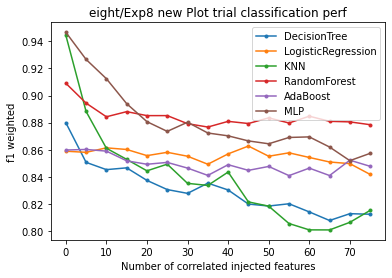

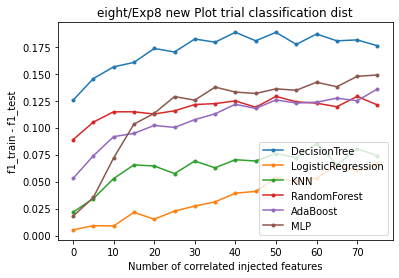

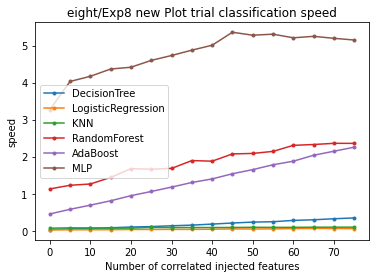

In [35]:
result_array = np.arange(0, 16 * 5, 5)
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="eight/Exp8 new Plot trial classification perf", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="eight/Exp8 new Plot trial classification dist", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=result_array, x_label="Number of correlated injected features", results=results_for_each_algorithm, title="eight/Exp8 new Plot trial classification speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

In [36]:
column_name = 'Injected features'
column_values = result_array


# Call the function with the new parameters
generate_latex_tables_and_save_files(results_for_each_algorithm, CLASSIFICATION_ALGORITHMS, column_name, column_values, 'eight')


### Experiment 9: Introducing new features as a linear combination of existing features

In [37]:
results_for_each_algorithm = perform_experiment(9,X,y,CLASSIFICATION_ALGORITHMS,0)

print(results_for_each_algorithm)

Training for DecisionTree...
Training for DecisionTree...
(1000, 6)
Training for DecisionTree...
(1000, 7)
Training for DecisionTree...
(1000, 8)
Training for DecisionTree...
(1000, 9)
Training for DecisionTree...
(1000, 10)
Training for DecisionTree...
(1000, 11)
Training for DecisionTree...
(1000, 12)
Training for DecisionTree...
(1000, 13)
Training for DecisionTree...
(1000, 14)
Training for DecisionTree...
(1000, 15)
DEBUG 10
Training for LogisticRegression...
Training for LogisticRegression...
(1000, 6)
Training for LogisticRegression...
(1000, 7)
Training for LogisticRegression...
(1000, 8)
Training for LogisticRegression...
(1000, 9)
Training for LogisticRegression...
(1000, 10)
Training for LogisticRegression...
(1000, 11)
Training for LogisticRegression...
(1000, 12)
Training for LogisticRegression...
(1000, 13)
Training for LogisticRegression...
(1000, 14)
Training for LogisticRegression...
(1000, 15)
DEBUG 10
Training for KNN...
Training for KNN...
(1000, 6)
Training for KNN

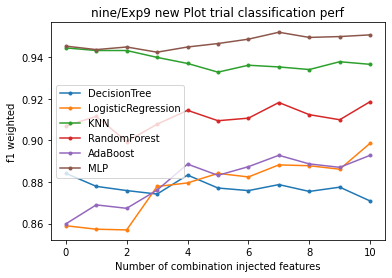

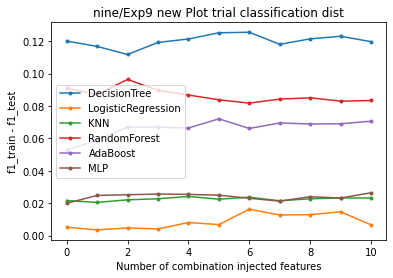

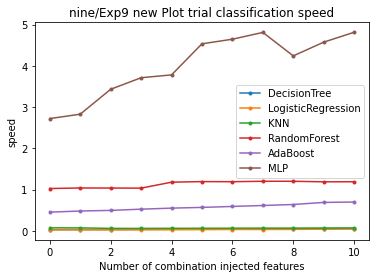

In [38]:
result_array = np.arange(0,11)
plot(x_axis_values=result_array, x_label="Number of combination injected features", results=results_for_each_algorithm, title="nine/Exp9 new Plot trial classification perf", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=result_array, x_label="Number of combination injected features", results=results_for_each_algorithm, title="nine/Exp9 new Plot trial classification dist", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=result_array, x_label="Number of combination injected features", results=results_for_each_algorithm, title="nine/Exp9 new Plot trial classification speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

In [39]:
column_name = 'Injected features'
column_values = result_array


# Call the function with the new parameters
generate_latex_tables_and_save_files(results_for_each_algorithm, CLASSIFICATION_ALGORITHMS, column_name, column_values, 'nine')


### Experiment 10: introducing 5 correlated features going from -1 to 1 correlation.

In [40]:
results_for_each_algorithm = perform_experiment(10,X,y,CLASSIFICATION_ALGORITHMS,-1)

print(results_for_each_algorithm)

Training for DecisionTree...
Correlation with the target feature: -1.0
Correlation with the target feature: -1.0
Correlation with the target feature: -1.0
Correlation with the target feature: -1.0
Correlation with the target feature: -0.9999999999999999
Training for DecisionTree...
Correlation with the target feature: -0.9537448932084677
Correlation with the target feature: -0.9548504744018965
Correlation with the target feature: -0.9544552944571137
Correlation with the target feature: -0.9405608483872281
Correlation with the target feature: -0.966747872511834
Training for DecisionTree...
Correlation with the target feature: -0.8991213428238868
Correlation with the target feature: -0.8987907663651954
Correlation with the target feature: -0.8882911072185726
Correlation with the target feature: -0.8649504068880693
Correlation with the target feature: -0.9193011216426581
Training for DecisionTree...
Correlation with the target feature: -0.8193226225598199
Correlation with the target featu

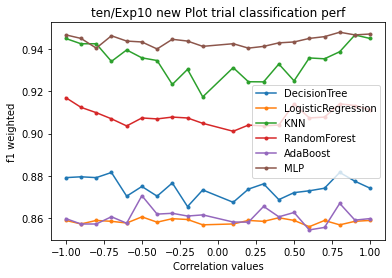

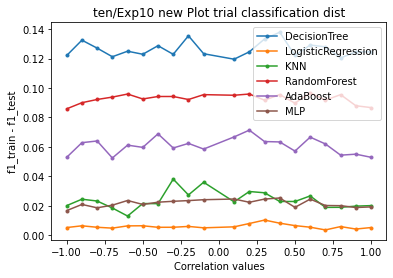

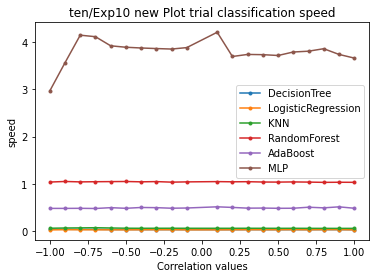

In [41]:
plot(x_axis_values=[-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], x_label="Correlation values", results=results_for_each_algorithm, title="ten/Exp10 new Plot trial classification perf", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=[-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], x_label="Correlation values", results=results_for_each_algorithm, title="ten/Exp10 new Plot trial classification dist", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=[-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], x_label="Correlation values", results=results_for_each_algorithm, title="ten/Exp10 new Plot trial classification speed", algorithms=CLASSIFICATION_ALGORITHMS, plot_type="speed")

In [42]:
column_name = 'Correlation Values'
column_values = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]


# Call the function with the new parameters
generate_latex_tables_and_save_files(results_for_each_algorithm, CLASSIFICATION_ALGORITHMS, column_name, column_values, 'ten')
